In [1]:
import sklearn
sklearn.__version__

'0.24.1'

## Data preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import silhouette_score
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import json
from api_keys import *

In [4]:
moosic = pd.read_csv("../data/big_df_audio_features.csv")
moosic.drop_duplicates(subset='name', inplace=True)
moosic.set_index(["name", "artist"], inplace=True)

In [5]:
#moosic.info()
moosic.dtypes

danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
dtype: object

In [6]:
moosic.isnull().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

In [7]:
moosic.drop(columns=["duration_ms", "key", "time_signature", "loudness", 'mode', "speechiness", "liveness"], inplace=True)

In [8]:
moosic.head(3)

,,danceability,energy,acousticness,instrumentalness,valence,tempo
name,artist,,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.658,0.259,0.694,0.000059,0.306,110.376
Saudade De Bahia,Antônio Carlos Jobim,0.742,0.399,0.217,0.000002,0.693,125.039
"Canta Canta, Minha Gente",Martinho Da Vila,0.851,0.730,0.453,0.000063,0.905,93.698


In [9]:
columns = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence', 'tempo']

moosic_sample = moosic.filter(columns)

## Modelling

### MinMaxScaler

In [10]:
minmax = MinMaxScaler(feature_range=(0,1))
minmax.fit(moosic_sample)
minmax_scaled = minmax.transform(moosic_sample)
minmax_scaled = pd.DataFrame(minmax_scaled, columns = moosic_sample.columns, index = moosic_sample.index)
minmax_scaled.head(3)

,,danceability,energy,acousticness,instrumentalness,valence,tempo
name,artist,,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.680455,0.259,0.696787,0.000060,0.310660,0.515800
Saudade De Bahia,Antônio Carlos Jobim,0.767322,0.399,0.217871,0.000002,0.703553,0.584322
"Canta Canta, Minha Gente",Martinho Da Vila,0.880041,0.730,0.454819,0.000064,0.918782,0.437862


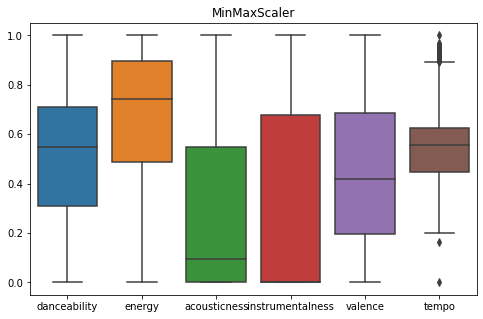

In [11]:
plt.subplots(figsize=(8, 5))
sns.boxplot(data=minmax_scaled.loc[:, moosic.columns])
plt.title('MinMaxScaler')
plt.show()

### QuantileTransformer

In [12]:
qtl_transformer = QuantileTransformer(n_quantiles=10, random_state=0)
qtl_scaled = qtl_transformer .fit_transform(moosic)
qtl_scaled = pd.DataFrame(qtl_scaled, columns = moosic.columns, index = moosic.index)
qtl_scaled.head(3)

,,danceability,energy,acousticness,instrumentalness,valence,tempo
name,artist,,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.702020,0.144318,0.800508,0.343393,0.380952,0.411439
Saudade De Bahia,Antônio Carlos Jobim,0.836074,0.203167,0.604861,0.235875,0.762667,0.605786
"Canta Canta, Minha Gente",Martinho Da Vila,0.932045,0.484225,0.716413,0.344482,0.942280,0.209747


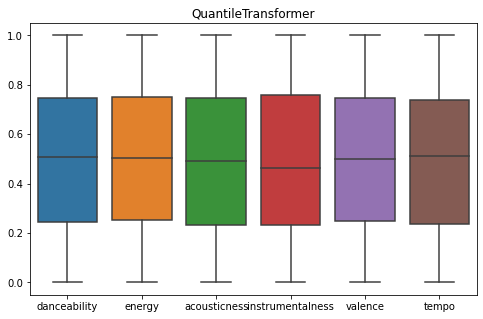

In [13]:
plt.subplots(figsize=(8, 5))
sns.boxplot(data=qtl_scaled.loc[:, moosic.columns])
plt.title('QuantileTransformer')
plt.show()

In [14]:
from sklearn.cluster import KMeans
moosic_kmeans = KMeans(n_clusters=12, random_state = 123).fit(qtl_scaled)

In [15]:
centroids = pd.DataFrame(moosic_kmeans.cluster_centers_)
centroids.columns = columns

#### Using inertia

In [16]:
moosic_kmeans.inertia_

619.4636481315272

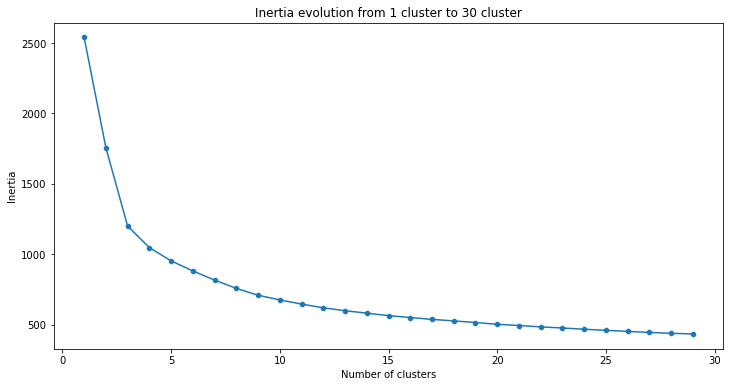

In [17]:
inertia = []

for i in range(1, 30): 
    inertia.append(KMeans(n_clusters=i).fit(qtl_scaled).inertia_)

fig, ax = plt.subplots(figsize=(12, 6))
plt.title(f'Inertia evolution from 1 cluster to 30 cluster')
sns.lineplot(x=range(1, 30), y=inertia)
sns.scatterplot(x=range(1, 30), y=inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### Silhouette Score

In [18]:
silhouette_score(qtl_scaled, moosic_kmeans.labels_)

0.23073716486189774

The score of 0 means that clusters are overlapping. Close to 1 means clusters are well apart from each other and clearly distinguished. Close - 1 means that data belonging to clusters may be wrong/incorrect.

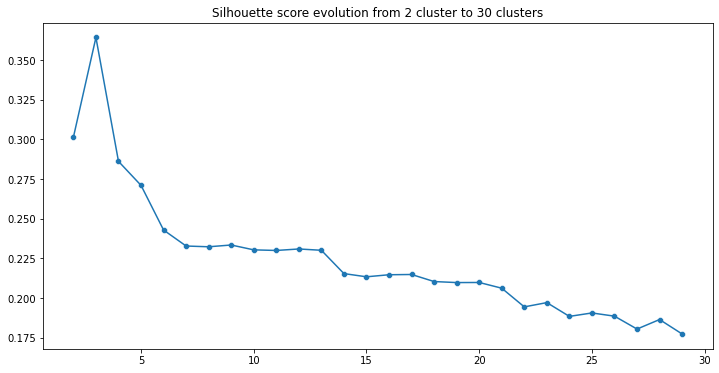

In [19]:
sil_score = []

for i in range(2, 30): 
    labels = KMeans(n_clusters=i).fit(qtl_scaled).labels_
    sil_score.append(silhouette_score(qtl_scaled, labels))

fig, ax = plt.subplots(figsize=(12, 6))
plt.title(f'Silhouette score evolution from 2 cluster to 30 clusters')
sns.lineplot(x=range(2, 30), y=sil_score)
sns.scatterplot(x=range(2, 30), y=sil_score)
plt.show()

In [30]:
# Check highest silhouette_score given number of clusters in range (2, 100)

list_of_silouetthes = {'number':[],'score':[]}
for i in range(2,100):
    
    moosic_kmeans = KMeans(n_clusters=i).fit(qtl_scaled)
    list_of_silouetthes['score'].append(silhouette_score(qtl_scaled, moosic_kmeans.labels_))
    list_of_silouetthes['number'].append(i)


    
sil = pd.DataFrame.from_dict(list_of_silouetthes)
sil

,number,score
0,2,0.298288
1,3,0.362099
2,4,0.285006
3,5,0.270857
4,6,0.243213
...,...,...
93,95,0.169077
94,96,0.168165
95,97,0.171810
96,98,0.167193


In [41]:
sil.score.max()

0.36209854237348854

from range of 2-100 cluster number, n_clusters=6 has the highest Silhouette Score which equals to 0.30466612911155566. According to visualisation result of the Silhouette score I will consider 13 as the best number of the clusters. 

In [20]:
from sklearn.cluster import KMeans
moosic_kmeans = KMeans(n_clusters=13, random_state=123).fit(qtl_scaled)

In [21]:
centroids = pd.DataFrame(moosic_kmeans.cluster_centers_)
centroids.columns = columns
centroids

,danceability,energy,acousticness,instrumentalness,valence,tempo
0,0.186411,0.819824,0.108410,0.742116,0.270638,0.801272
1,0.820352,0.494849,0.529561,0.393979,0.801061,0.316381
2,0.285806,0.089146,0.921531,0.820878,0.216508,0.736710
3,0.561517,0.662498,0.383886,0.073115,0.570334,0.694745
4,0.631986,0.618960,0.308122,0.546101,0.324423,0.623965
5,0.205419,0.070649,0.934630,0.820707,0.154028,0.152619
6,0.807640,0.485193,0.548995,0.002621,0.740179,0.277307
7,0.716008,0.422638,0.626496,0.102527,0.844152,0.772548
8,0.488124,0.292609,0.667835,0.145795,0.426445,0.782817
9,0.493476,0.263417,0.707216,0.169504,0.455152,0.222349


In [22]:
clusters = moosic_kmeans.predict(qtl_scaled)

In [23]:
qtl_scaled["cluster"] = clusters
test_sample = qtl_scaled.groupby('cluster').sample(5)

In [24]:
centroid_dis = pd.DataFrame(data=moosic_kmeans.cluster_centers_, columns= qtl_scaled.drop("cluster", axis=1).columns)

In [25]:
qtl_scaled['cluster'] = moosic_kmeans.labels_

In [28]:
cluster_0_songs = qtl_scaled.query('cluster == 0')
cluster_0_songs.head(30)

,,danceability,energy,acousticness,instrumentalness,valence,tempo,cluster
name,artist,,,,,,,
Come Saturday,The Pains Of Being Pure At Heart,0.085835,0.839243,0.006641,0.945069,0.573964,0.934797,0
Game Of Pricks,Guided By Voices,0.283816,0.692593,0.168153,0.562033,0.431013,0.786900,0
Let's Get Out Of Here,Les Savy Fav,0.136876,0.986450,0.237459,0.683782,0.267816,0.914121,0
Absolutely Cuckoo,The Magnetic Fields,0.305556,0.748148,0.228306,0.771394,0.564103,0.802335,0
Waterfall,The Fresh & Onlys,0.123994,0.766667,0.474747,0.852585,0.681778,0.969549,0
"Archie, Marry Me",Alvvays,0.199678,0.657143,0.124957,0.917603,0.828283,0.873702,0
Read My Mind,The Killers,0.165862,0.587302,0.052609,0.702323,0.769778,0.897775,0
She's A Rainbow - Stereo Full Version / With Intro,The Rolling Stones,0.240338,0.727778,0.040880,0.735534,0.280460,0.827755,0
The Waiting,Angel Olsen,0.268116,0.737037,0.109099,0.696618,0.757333,0.959184,0


In [19]:
cluster_0_songs = cluster_0_songs.assign(distance = 0)

In [35]:
# Create a list of the playlists. Iterate 13 times, get through all clusters and get the distance between all clusters and data points and output 20 songs with the smallest values. 

list_of_playlists= []
for i in range(13):
    list_of_playlists.append(qtl_scaled.query('cluster == @i'))
    list_of_playlists[i] = list_of_playlists[i].assign(distance=0)
    for j, song in list_of_playlists[i].iterrows():
        total = sum(((song.iloc[pos]- centroid_dis.iloc[1][pos])**2) for pos in range(qtl_scaled.shape[1]-3))**(1/2)
        list_of_playlists[i].loc[j,'distance'] = total
    list_of_playlists[i] = list_of_playlists[i].sort_values('distance').head(20)
    list_of_playlists[i] = list_of_playlists[i].reset_index()

In [37]:
scope = 'playlist-modify-public'
username = spotify_username
#redirectUri = 'http://localhost:8888/callback'

token = SpotifyOAuth(scope=scope, username=spotify_username, client_id=spotify_client_id, client_secret=spotify_client_secret, redirect_uri='http://localhost:8000/callback')
spotifyObject = spotipy.Spotify(auth_manager = token)

In [38]:
for i, playlist in enumerate(list_of_playlists):
    playlist_name = f'Playlist_cluster_{i}'
    playlist_description= ''
    playlist_id = spotifyObject.user_playlist_create(user=spotify_username ,name=playlist_name,public=True,description=playlist_description)['id']
    list_of_songs = []
    for index, song in playlist.iterrows():
        result = spotifyObject.search(q=f"{song['name']} artist:{song['artist']}",type='track',limit=1)
        try:
            list_of_songs.append(result['tracks']['items'][0]['uri'])
        except:
            continue
    spotifyObject.user_playlist_add_tracks(user=spotify_username, playlist_id=playlist_id, tracks=list_of_songs)

In [30]:
#Calculate the distance between the centroids and data points

for i, song in cluster_0_songs.iterrows():
    total = sum(((song.iloc[pos]- centroid_dis.iloc[1][pos])**2) for pos in range(qtl_scaled.shape[1]-3))**(1/2)
    cluster_0_songs.loc[i,'distance'] = total

playlist_0 = cluster_0_songs.sort_values('distance').reset_index().head(30)
playlist_0

C:\Users\akbar\anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\akbar\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,name,artist,danceability,energy,acousticness,instrumentalness,valence,tempo,cluster,distance
0,Shot Me Down (feat. Skylar Grey) - Radio Edit,David Guetta,0.303140,0.541838,0.453001,0.566945,0.046779,0.957735,0,0.552716
1,Major Happy,Fred V & Grafix,0.386940,0.663492,0.233945,0.559304,0.125977,0.922820,0,0.575333
2,Tonight - Cutline Remix,Danny Byrd,0.408382,0.646032,0.157134,0.449892,0.186120,0.922646,0,0.578277
3,Valley of the Shadows - Chase & Status Remix,Origin Unknown,0.492637,0.829787,0.398825,0.796480,0.411477,0.922834,0,0.631411
4,Innocence,NERO,0.334308,0.489712,0.226826,0.695192,0.090617,0.774321,0,0.647026
5,Scary Monsters and Nice Sprites,Skrillex,0.500669,0.855792,0.246427,0.725550,0.383394,0.792179,0,0.650063
6,Dark Transmission,Vader,0.402534,0.757407,0.124810,0.558430,0.336996,0.896001,0,0.659072
7,Ghosts n Stuff - Sub Focus Remix,deadmau5,0.414230,0.622222,0.143469,0.722290,0.363858,0.922832,0,0.661826
8,I Take,Altar,0.359649,0.825059,0.225532,0.561105,0.252874,0.603507,0,0.664568
9,Through The Night - Radio Edit,Drumsound,0.318841,0.740741,0.170357,0.457151,0.356532,0.924214,0,0.667079


In [27]:
# playlist_name = 'playlist_cluster_0'
# playlist_description= ''
# playlist_id = spotifyObject.user_playlist_create(user=spotify_username, name=playlist_name, public=True, description=playlist_description)['id']
# list_of_songs = []
# for index, song in playlist_0.iterrows():
#     result = spotifyObject.search(q=f"{song['name']} artist:{song['artist']}",type='track',limit=1)
#     try:
#         list_of_songs.append(result['tracks']['items'][0]['uri'])
#     except:
#         continue
        
# spotifyObject.user_playlist_add_tracks(user=spotify_username, playlist_id=playlist_id, tracks=list_of_songs)